# Author : DIF Akli
# Etudinat M2 IAA - Univ. Paris 8

In [29]:
import pandas as pd
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.regularizers import l1

from keras.models import save_model


In [30]:
df:DataFrame = pd.read_csv('./data/train.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Exploration des données :

### Variables catégorielles :

/tmp/ipykernel_29656/796957031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Gender", ax=axs[0][0], data=df, palette="Blues")
/tmp/ipykernel_29656/796957031.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Married", ax=axs[0][1], data=df, palette="Greens")
/tmp/ipykernel_29656/796957031.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Education", ax=axs[0][2], data=df, palette="Reds")
/tmp/ipykernel_29656/796957031.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in

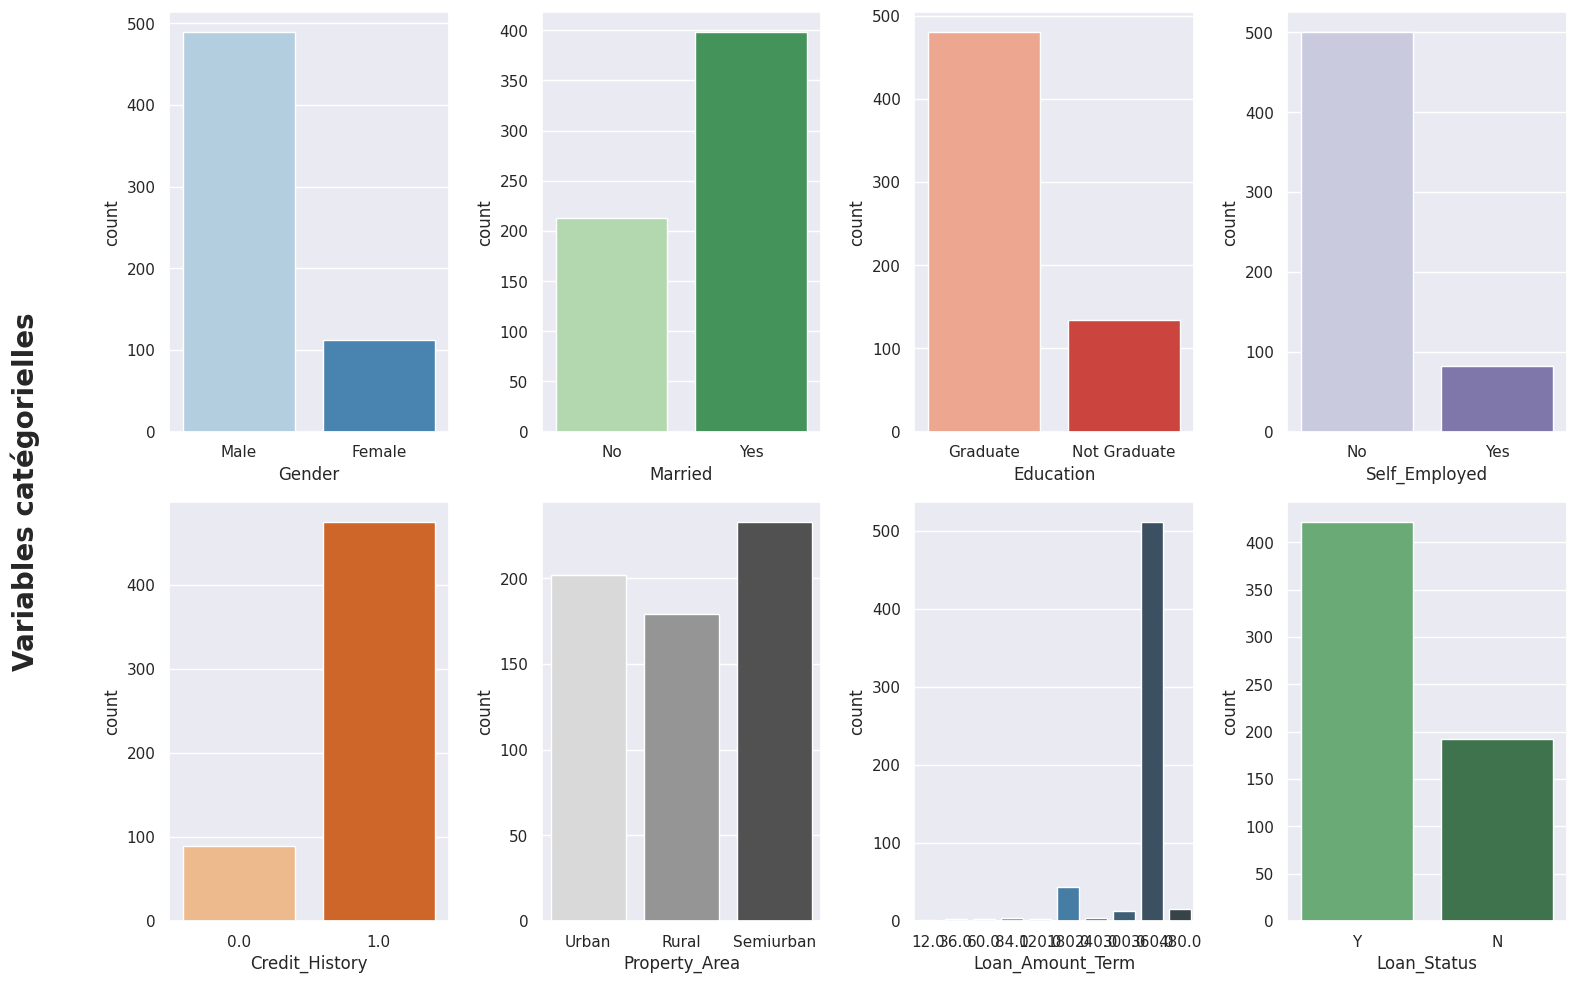

In [31]:
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

sns.countplot(x="Gender", ax=axs[0][0], data=df, palette="Blues")
sns.countplot(x="Married", ax=axs[0][1], data=df, palette="Greens")
sns.countplot(x="Education", ax=axs[0][2], data=df, palette="Reds")
sns.countplot(x="Self_Employed", ax=axs[0][3], data=df, palette="Purples")

sns.countplot(x="Credit_History", ax=axs[1][0], data=df, palette="Oranges")
sns.countplot(x="Property_Area", ax=axs[1][1], data=df, palette="Greys")
sns.countplot(x="Loan_Amount_Term", ax=axs[1][2], data=df, palette="Blues_d")
sns.countplot(x="Loan_Status", ax=axs[1][3], data=df, palette="Greens_d")

fig.text(-0.05, 0.5, 'Variables catégorielles', va='center', rotation='vertical', fontsize=20, fontweight='bold')


plt.tight_layout()
plt.show()

### Remarques :

* On remarque que les données sont très déséquilibrées, il y a beaucoup plus d'Hommes que de Femms dans le dataset.

* On peut déduire que le nombre de demandeur marrié est plus elevé que le nombre de deandeur célibataire.

* On remarque que la majorité des demandeurs sont des hommes, mariés et diplômés.

* Le nombre de demandeurs qui sont salariés est plus elevé que le nombre de demandeurs qui sont des travailleurs indépendants.

* On a plus de demandeurs avec un historique de crédit positif que de demandeurs avec un historique de crédit négatif.

* Le nombre de demandeurs dans les differents zones (Rurale, Semi-urbaine, Urbaine) est relativement proche.

* Le nombre de demandes acceptées est plus elevé que le nombre de demandes refusées.

* On remarque que 360 jours est la durée la plus fréquente des prêts.


### Variables numériques :

In [32]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


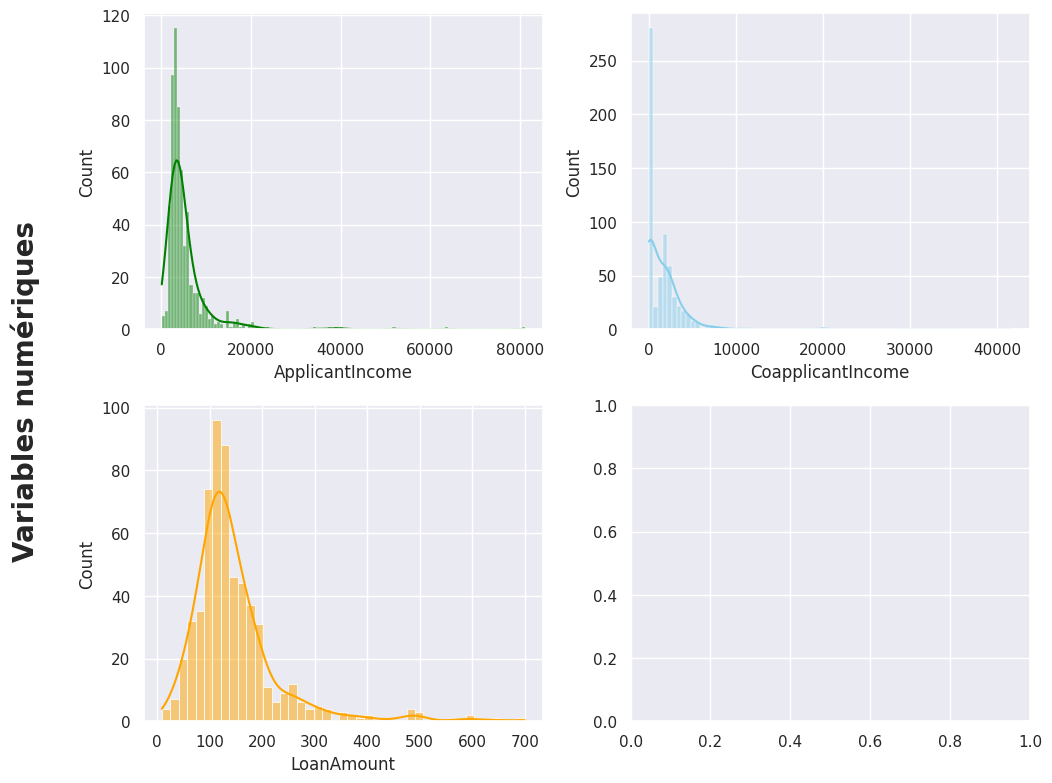

In [33]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange')

fig.text(-0.05, 0.5, 'Variables numériques', va='center', rotation='vertical', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## Préparation des données :

In [34]:
print('***Data post cleaning***')
print(df.shape)
print('***Columns***')
print(df.columns)

df = df.drop(['Loan_ID'], axis = 1)


print(df.isnull().sum())


***Data post cleaning***
(614, 13)
***Columns***
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [35]:

df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)

df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(),inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(),inplace=True)

print (df.columns)

df = pd.get_dummies(df, dtype=int)

# Drop columns
df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 
              'Self_Employed_No', 'Loan_Status_N'], axis = 1)

new = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
       'Education_Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed',
       'Loan_Status_Y': 'Loan_Status'}
       
df.rename(columns=new, inplace=True)

df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

print('***null data***')
print(df.isnull().sum())
print('***Data post cleaning***')
print(df.shape)
print('***Columns***')
print(df.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
***null data***
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Gender                     0
Married                    0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education                  0
Self_Employed              0
Property_Area_Rural        0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status                0
dtype: int64
***Data post cleaning***
(614, 17)
***Columns***
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+

/tmp/ipykernel_29656/1577153875.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
/tmp/ipykernel_29656/1577153875.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

## Equilibré les données :

In [36]:
X = df.drop(['Loan_Status'], axis=1)
Y = df['Loan_Status']

X, Y = SMOTE().fit_resample(X, Y)

print (np.histogram(Y))


(array([422,   0,   0,   0,   0,   0,   0,   0,   0, 422]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


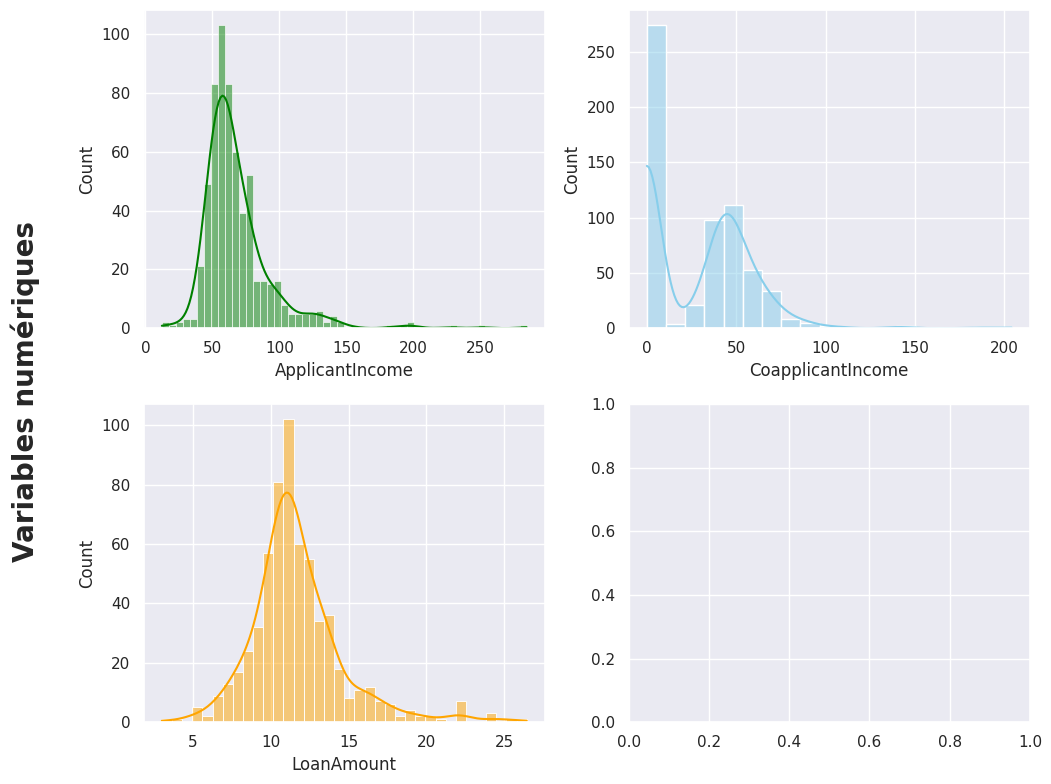

In [37]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange')

fig.text(-0.05, 0.5, 'Variables numériques', va='center', rotation='vertical', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## Application d'un StandardScaler sur l'enselble des données :

In [38]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)

print (X.columns)
print (X_scaled[0])

pickle.dump(scaler, open('models/scaler.pkl', 'wb'))




Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education', 'Self_Employed', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')
[ 0.28393815 -0.96596428 -0.15629361  0.27742631  0.57192433  0.51329626
 -1.16796646  0.95141572 -0.38509651 -0.37694018 -0.27164563  0.61386907
 -0.33464826 -0.57005329 -0.65797962  1.60507669]


### Division des données en un ensemble d'entraînement et un ensemble de test

In [39]:

X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print('***Training Set***')
print(X_train_scaled.shape)
print(Y_train.shape)
print('***Validation Set***')
print('***Test Set***')
print(X_test_scaled.shape)
print(Y_test.shape)


***Training Set***
(675, 16)
(675,)
***Validation Set***
***Test Set***
(169, 16)
(169,)


## Implémentation d'un ensemble de méthodes d'apprentissage automatique

### Méthode 1 : Régression linéaire

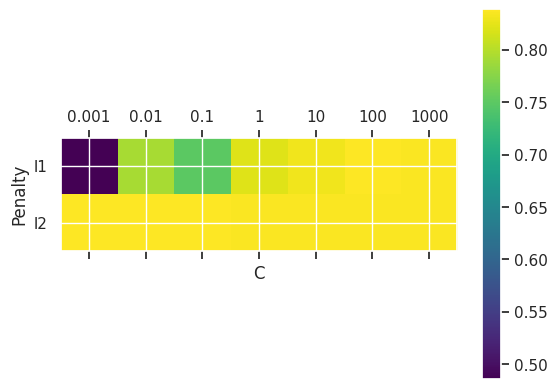

*****Sans normalisation*****
***Confusion Matrix***
[[69 25]
 [ 3 72]]
***Accuracy Score***
0.834319526627219
***Recall Score***
0.96
***f-measure***
0.8372093023255814
***precision***
0.7422680412371134
***ROC AUC***
0.8470212765957447


In [40]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}

grid_search = GridSearchCV(LogisticRegression(max_iter=100), param_grid, cv=10)
grid_search.fit(X_train_scaled, Y_train)
mean_test_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

mean_test_scores = np.array(mean_test_scores)

# Reshape mean_test_scores to a 2D array where the first dimension is penalty and the second is C
mean_test_scores = mean_test_scores.reshape(len(param_grid['penalty']), len(param_grid['C']))


# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create a color map
cax = ax.matshow(mean_test_scores, cmap='viridis')

# Create a color bar
fig.colorbar(cax)

# Set the ticks
ax.set_xticks(np.arange(len(param_grid['C'])))
ax.set_yticks(np.arange(len(param_grid['penalty'])))

# Set the tick labels
ax.set_xticklabels(param_grid['C'])
ax.set_yticklabels(param_grid['penalty'])

# Set the labels for the x and y axis
plt.xlabel('C')
plt.ylabel('Penalty')

# Show the plot
plt.show()

# Use the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
pred = best_model.predict(X_test_scaled)
print ("*****Sans normalisation*****")
print('***Confusion Matrix***')
print(confusion_matrix(Y_test, pred))
print('***Accuracy Score***')
print(accuracy_score(Y_test, pred))
print('***Recall Score***')
print(recall_score(Y_test, pred))
print ("***f-measure***")
print(f1_score(Y_test, pred))
print ("***precision***")
print(precision_score(Y_test, pred))
print('***ROC AUC***')
print(roc_auc_score(Y_test, pred))

## Methode 2 : Random forests 

Best value for n_estimators:  23


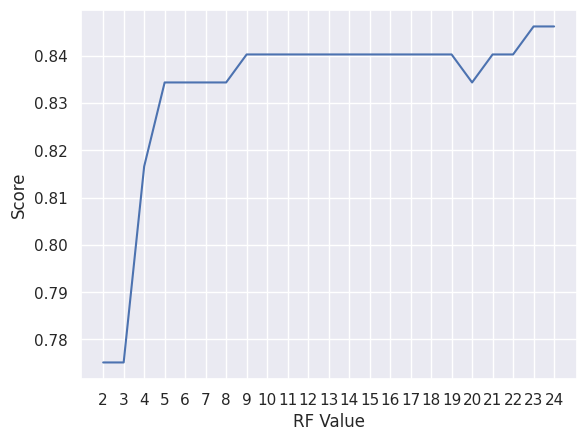

Random Forest Accuracy:  84.62%
*****Sans normalisation*****
***Confusion Matrix***
[[71 23]
 [ 3 72]]
***Accuracy Score***
0.8461538461538461
***Recall Score***
0.96
***f-measure***
0.8470588235294118
***precision***
0.7578947368421053
***ROC AUC***
0.857659574468085


In [41]:
scoreListRF = []
for i in range(2,25):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    RFclassifier.fit(X_train_scaled, Y_train)
    scoreListRF.append(RFclassifier.score(X_test_scaled, Y_test))

n_es = scoreListRF.index(max(scoreListRF))+2
print("Best value for n_estimators: ", n_es)

plt.plot(range(2,25), scoreListRF)
plt.xticks(np.arange(2,25,1))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RFAcc = max(scoreListRF)
print("Random Forest Accuracy:  {:.2f}%".format(RFAcc*100))

rf1 = RandomForestClassifier(n_estimators=1000, random_state=1, max_leaf_nodes=n_es)
rf1.fit(X_train_scaled, Y_train)

pred = rf1.predict(X_test_scaled)


print ("*****Sans normalisation*****")
print('***Confusion Matrix***')
print(confusion_matrix(Y_test, pred))
print('***Accuracy Score***')
print(accuracy_score(Y_test, pred))
print('***Recall Score***')
print(recall_score(Y_test, pred))
print ("***f-measure***")
print(f1_score(Y_test, pred))
print ("***precision***")
print(precision_score(Y_test, pred))
print('***ROC AUC***')
print(roc_auc_score(Y_test, pred))




## Méthode 3 : SVM

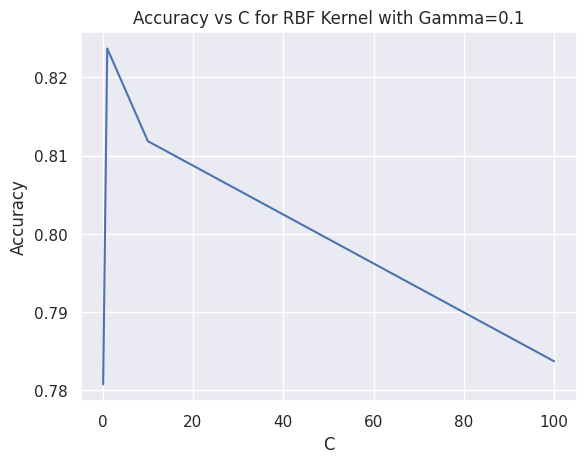

In [42]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm = SVC(random_state=0)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, Y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)

subset = cv_results[(cv_results.param_kernel == 'rbf') & (cv_results.param_gamma == 0.1)]
plt.plot(subset['param_C'], subset['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for RBF Kernel with Gamma=0.1')
plt.show()

## Méthode 4 : Réseau de neurones

/home/akli/py_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Confusion Matrix
[[94  0]
 [75  0]]
Accuracy Score
0.5562130177514792
Recall Score
0.0
f-measure
0.0
precision
0.0
ROC AUC
0.5


/home/akli/py_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


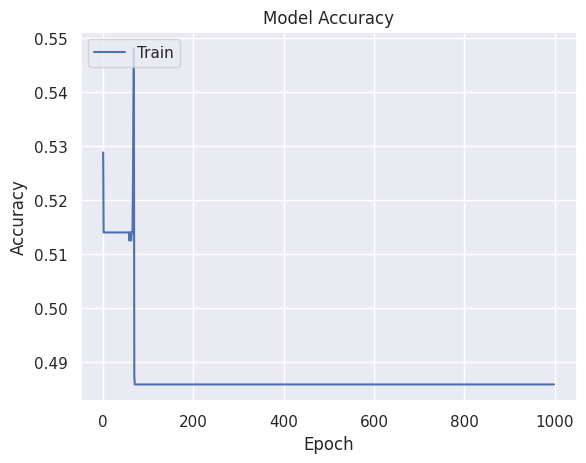

In [43]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', bias_initializer='ones', activity_regularizer=l1(0.01)))
model.add(Dense(128, activation='relu', bias_initializer='ones', activity_regularizer=l1(0.01)))
model.add(Dense(1, activation='sigmoid', bias_initializer='ones', activity_regularizer=l1(0.01)))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train_scaled, Y_train, epochs=1000, verbose=0)


pred = model.predict(X_test_scaled)
pred = np.round(pred)

print('Confusion Matrix')
print(confusion_matrix(Y_test, pred))
print('Accuracy Score')
print(accuracy_score(Y_test, pred))
print('Recall Score')
print(recall_score(Y_test, pred))
print("f-measure")
print(f1_score(Y_test, pred))
print("precision")
print(precision_score(Y_test, pred))
print('ROC AUC')
print(roc_auc_score(Y_test, pred))

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

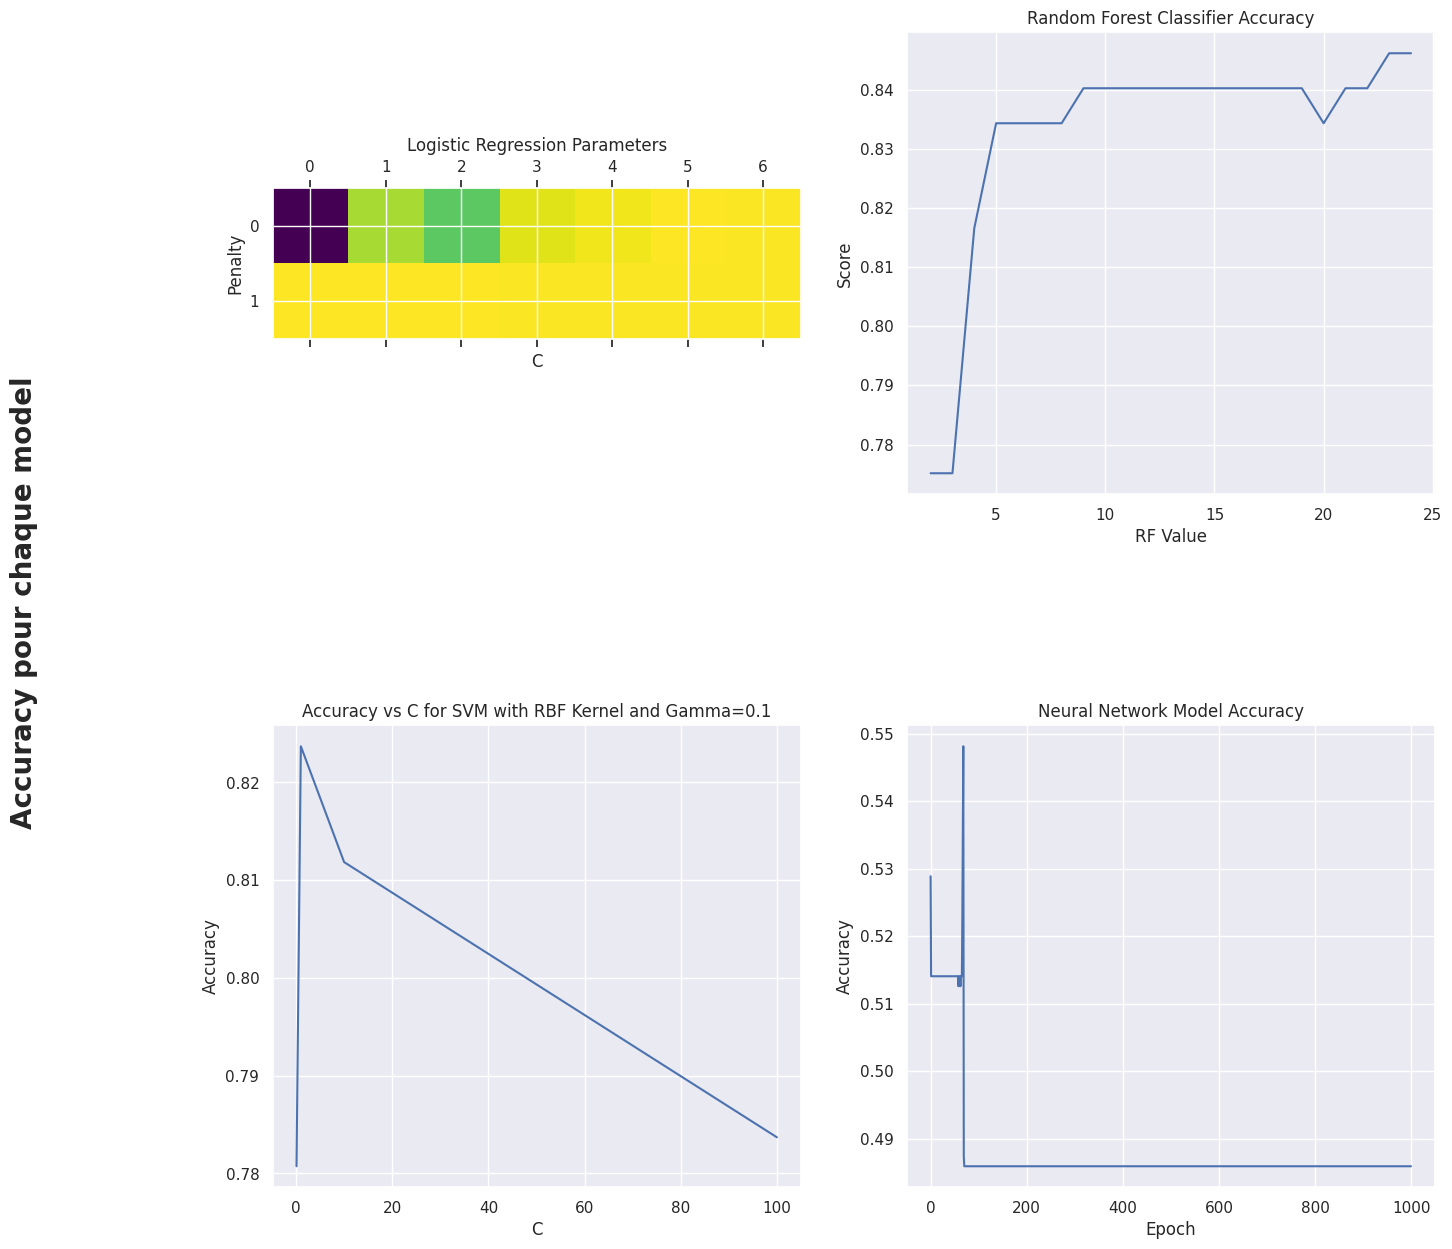

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

plt.subplots_adjust(hspace = 0.5)


axs[0, 0].matshow(mean_test_scores, cmap='viridis')
axs[0, 0].set_xlabel('C')
axs[0, 0].set_ylabel('Penalty')
axs[0, 0].set_title('Logistic Regression Parameters')



axs[0, 1].plot(range(2,25), scoreListRF)
axs[0, 1].set_xlabel("RF Value")
axs[0, 1].set_ylabel("Score")
axs[0, 1].set_title("Random Forest Classifier Accuracy")

axs[1, 0].plot(subset['param_C'], subset['mean_test_score'])
axs[1, 0].set_xlabel('C')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Accuracy vs C for SVM with RBF Kernel and Gamma=0.1')


axs[1, 1].plot(history.history['accuracy'])
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Neural Network Model Accuracy')

fig.text(-0.05, 0.5, 'Accuracy pour chaque model', va='center', rotation='vertical', fontsize=20, fontweight='bold')

plt.show()

## Conclusion :

En comparant les résultats des différentes méthodes, on remarque que la méthode des Random Forests est la plus performante avec un accuracy score de 0.93.

## Sauvegarder le modèle :

In [45]:
filename = 'models/rf_model.sav'
pickle.dump(rf1, open(filename, 'wb'))


filename = 'models/lr_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

filename = 'models/svm_model.sav'
pickle.dump(svm, open(filename, 'wb'))

filename = 'models/nn_model.keras'
save_model (model, filename)
